In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText
from cartopy.mpl.geoaxes import GeoAxes
import cartopy

In [4]:
import sys
sys.path.append('scripts')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [5]:
datadir='data/'
sig2_val = 37.06
mdict = {mod:{} for mod in ['CM4','ESM4']}
for mod in mdict:
    for exp in ['control','antwater']:
        head = '%s_%s'%(mod,exp)
        files = glob.glob(datadir+head+'_so_*_dVdtmap_at_sigma2_%s.nc'%('%.2f'%sig2_val).replace('.',''))
        
        if len(files)>1:
            print('WARNING: More than one file for '+head)
        elif len(files)==0:
            print('ERROR: No file available for '+head)
            mdict[mod][exp_str] = []
            continue
        
        print('Loading '+os.path.basename(files[0]))
        exp_str = 'ctr' if exp=='control' else 'exp'
        mdict[mod][exp_str] = xr.open_dataset(files[0]).dVdt

Loading CM4_control_so_0281to0380_dVdtmap_at_sigma2_3706.nc
Loading CM4_antwater_so_0051to0070_dVdtmap_at_sigma2_3706.nc
Loading ESM4_control_so_0121to0220_dVdtmap_at_sigma2_3706.nc
Loading ESM4_antwater_so_0051to0070_dVdtmap_at_sigma2_3706.nc


### Figure 9

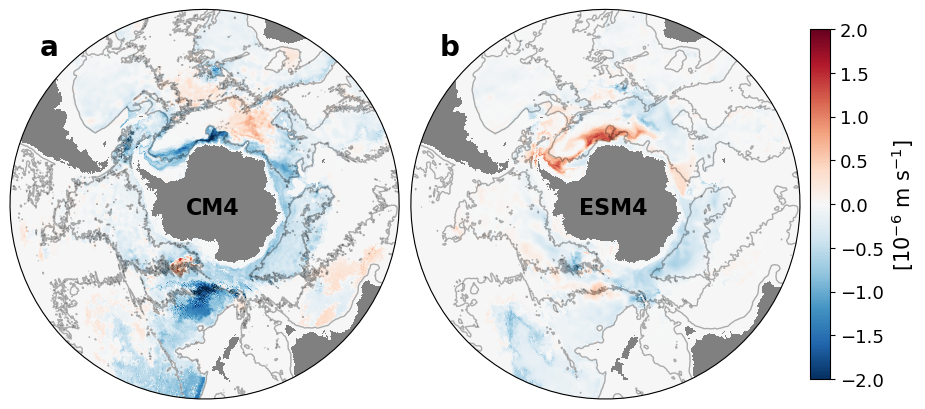

In [6]:
lttr = ['a','b']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), 
                         subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),
                                         facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.1, wspace=0.03)

for i, mod in enumerate(mdict):
    
    # Load the static grid data
    if mod == 'CM4':
        subdir = 'CM4_piControl_C'
        grid = xr.open_dataset(datadir+subdir+'_ocean_monthly.static.nc')
    elif mod == 'ESM4':
        subdir = 'ESM4_piControl_D'
        grid = xr.open_dataset(datadir+subdir+'_ocean_monthly.static.nc')
    else:
        print('grid is not available for'+mod)
        
    grid = grid[['geolon','geolat','wet','deptho']].rename({'xh':'x', 'yh':'y', 'geolon':'lon', 'geolat':'lat'})
    ds_so = grid.where(grid.lat<-30,drop=True)
    

    axes[i].set_extent([-300, 60, -30, -90], cartopy.crs.PlateCarree())
    axes[i].set_boundary(circle, transform=axes[i].transAxes)
    
    da = (mdict[mod]['exp'].mean('mem')-mdict[mod]['ctr'])*1e6
    p = da.where(ds_so.wet==1).plot(ax=axes[i], x='x', y='y', vmin=-2, vmax=2, cmap='RdBu_r',
                                    add_colorbar=False, add_labels=False,transform=cartopy.crs.PlateCarree())
    ds_so.deptho.plot.contour(ax=axes[i], x='x', y='y', levels=[4000.0], linewidths=1, colors='k',
                              alpha=0.3,add_labels=False,transform=cartopy.crs.PlateCarree())
    axes[i].add_artist(AnchoredText(mod,loc='center', prop={'size': 16, 'fontweight': 'bold'}, frameon=False,
                                    bbox_to_anchor=(0.52, 0.49), bbox_transform=axes[i].transAxes))
    axes[i].annotate(lttr[i],xy=(0.1, 0.9), xycoords=axes[i].transAxes, textcoords='offset points',
                     fontsize=20, fontweight='bold',ha='center', va='center')

# Add separate colorbar
cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cb = fig.colorbar(p, cax=cax, ticks=np.arange(-2,2.5,0.5), orientation='vertical', shrink=0.9, pad=0.02)
cb.set_label(r'[10$^{-6}$ m s$^{-1}$]', fontsize=15)
cb.ax.tick_params(labelsize=13)
plt.savefig('dVdt_map.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

**Figure 9**: Spatial distribution of $dV/dt$ anomalies evaluated at the upper density bound of the AABW ($\sigma_2$ = 37.05) in (a) CM4 and (b) ESM4. The anomalies are calculated from the average over the years 51-70 of the Antwater experiment minus the 100-year average of the Control. Note that $dV/dt$ is divided by the horizontal area of a grid cell to render units of $\mbox{m}~\mbox{s}^{-1}$. The light gray lines denote contours of bottom topography (4000-m isobath).